<p><strong><font size="6""><center>Prueba Analítica: Modelo Opciones de Pago</center></font></strong></p>
<br>

<div align="center"><img alt="logo bancolombia"  src="https://www.bancolombia.com/wcm/connect/a67af2d6-c768-4f4f-a33b-fd58074f7ce9/logo-bancolombia-black.svg?MOD=AJPERES" align="center" hspace="10px" vspace="0px"></div>

# **1. Objetivo:**

<h5 align="justify">Esta prueba analítica tiene como objetivo diseñar y desarrollar un modelo de clasificación para predecir a un mes si un cliente que entro en Mora de alguna de las obligaciones crediticias que tiene con el banco, aceptará o no una de sus opciones pago, y asi contribuir a que el índice de cartera vencida del banco se ralentice.</h5>


<h5 align="justify">Para la construcción del modelo, trabajaremos con 5 datasets así:</h5>



*   4 serán usados para hacer el descriptivo, limpieza de datos, selección de variables, entrenamiento, testeo y validación
*   1 dataset contiene datos que se usarán para pronosticar el 202401 y evaluar el comportamiento de predicción del modelo con la métrica F1 Score.


**Nota:** El dataset que contiene la variable dependiente "prueba_op_base_pivot_var_rpta_alt_enmascarado_trtest" será tratada como la tabla pivote.


# **2. Metodología**

1. Empezaremos entendiendo inicialmente el problema de clasificación que nos presentan de la aceptación o no de las opciones de pago por parte de los clientes (variable objetivo o dependiente).

2. Se define para este problema la métrica de F1 Score para medir el performance del modelo.

3. Luego procederemos con la recolección u obtención de los datos alojados en Kaggle.

4. Realizamos un análisis de los Dataframe que tenemos para la solución del problema, y posteriormente realizamos el preprocesamiento de los datos:
  *   Limpieza de datos
  *   Manejo de valores perdidos o ausentes
  *   Transformación de variables categóricas con Get Dummies
  *   Estandarización de los datos con MixMaxScaler

5. Realizamos la selección de características apoyados con RFECV

6. Entrenamos diferentes modelos de clasificación para encontrar el que mejor performance presente para nuestros datos

7. Pronosticarémos con los datos del 202401

**Nota:** En todo el proceso me apoyé del archivo "Metadata" que compartieron en donde hay detalle del tipo de dato y un comentario de cada una de las variables de los datasets que ayudan a conocer más la info con la que trabajaremos.

## **Creación de Dataframes**

* <H5 align="justify">Empezaremos obteniendo los archivos del dataset de Kaggle. Para esto instalaremos la librería necesaria y posteriormente subiremos el archivo necesario para el API de Kaggle desde el usuario "spalaciov", con el fin de que nos autoricen la descarga del dataset para trabajarlo desde Colab.</H5>

In [1]:
# Instalar la biblioteca kaggle
!pip install kaggle

In [2]:
from google.colab import files

In [3]:
#subimos el archivo con el API de Kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"spalaciov","key":"e3502d9041aa8233e4fc3b1bec9a2898"}'}

In [4]:
#Esta creando un directorio oculto de kaggle

! mkdir ~/.kaggle

In [5]:
#Con esta sentencia vamos a copiar el archivo "Kaggle.json" que tiene los accesos del usuario al directorio creado

! cp kaggle.json ~/.kaggle/

In [6]:
#Con esta sentencia vamos a dar permisos de acceso al directorio

!chmod 600 ~/.kaggle/kaggle.json

In [7]:
#Con este sentencia descargamos los datasets que vamos usar para el modelo

!kaggle competitions download -c prueba-analitica-modelo-opciones-de-pago

 97% 335M/344M [00:03<00:00, 93.9MB/s]
100% 344M/344M [00:03<00:00, 101MB/s] 


In [8]:
#Descomprimo los archivos

!unzip prueba-analitica-modelo-opciones-de-pago.zip

Archive:  prueba-analitica-modelo-opciones-de-pago.zip
  inflating: Metadata.xlsx           
  inflating: prueba_op_base_pivot_var_rpta_alt_enmascarado_oot.csv  
  inflating: prueba_op_base_pivot_var_rpta_alt_enmascarado_trtest.csv  
  inflating: prueba_op_maestra_cuotas_pagos_mes_hist_enmascarado_completa.csv  
  inflating: prueba_op_master_customer_data_enmascarado_completa.csv  
  inflating: prueba_op_probabilidad_oblig_base_hist_enmascarado_completa.csv  
  inflating: sample_submission.csv   


* Luego de obtener los datasets, importaremos algunas de las librerías necesarias y los dataframes.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

Sembraremos la semilla aleatoria para trabajar durante todo el proyecto, especialmente para la partición de las bases de datos en entrenamiento, test y validacion; y en la construcción de los modelos.

In [10]:
# Semilla sembrada
seed_value= 0

# 1. Sembraremos la semilla en todo el enterno
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. sembraremos la semnilla aleatoria
import random
random.seed(seed_value)

# 3. Sembraremos la semilla en numpy
np.random.seed(seed_value)

<H5 align="justify">Importaremos las bases de datos con las que trabajaremos y les asignaremos los siguientes nombres:</H5>

* df_goal= prueba_op_base_pivot_var_rpta_alt_enmascarado_trtest.csv - Información de variable objetivo para train

* df_oot= prueba_op_base_pivot_var_rpta_alt_enmascarado_oot* - lista de clientes y obligaciones a calificar en 2024/01

* df_models= prueba_op_probabilidad_oblig_base_hist_enmascarado_completa.csv* - Información de probabilidades de modelos desarrollados

* df_customer= prueba_op_master_customer_data_enmascarado_completa.csv* - información demográfica cliente

* df_payments= prueba_op_maestra_cuotas_pagos_mes_hist_enmascarado_completa.csv* - información de pagos obligaciones


In [11]:
#Cargaremos las bases descargadas para analizar

#crearé un diccionario con las variables que son tipo string segun el metadata de la tabla train con el fin de evitar las variables tipo object
dtype_train = {
'tipo_var_rpta_alt': 'string',
'banca': 'string',
'segmento': 'string',
'producto': 'string',
'producto_cons': 'string',
'aplicativo': 'string',
'rango_mora': 'string',
'desc_alternativa1': 'string',
'desc_alternativa2': 'string',
'desc_alternativa3': 'string',
'alter_posible1_2': 'string',
'alter_posible2_2': 'string',
'alter_posible3_2': 'string',
'descripcion_ranking_mejor_ult': 'string',
'descripcion_ranking_post_ult': 'string',
'marca_alt_rank': 'string',
'marca_alt_apli': 'string',
'pagos_tanque': 'string',
'marca_debito_mora': 'string',
'alternativa_aplicada_agr': 'string',
'marca_agrupada_rgo': 'string',
'marca_pago': 'string',
'marca_alternativa': 'string',
'marca_alternativa_orig': 'string'
}

df_train = pd.read_csv('/content/prueba_op_base_pivot_var_rpta_alt_enmascarado_trtest.csv',dtype=dtype_train)

df_oot = pd.read_csv('/content/prueba_op_base_pivot_var_rpta_alt_enmascarado_oot.csv')

df_models = pd.read_csv('/content/prueba_op_probabilidad_oblig_base_hist_enmascarado_completa.csv')

#crearé un diccionario con las variables que son tipo string segun el metadata de la tabla customer con el fin de evitar las variables tipo object
dtype_customer = {
'tipo_cli': 'string',
'ctrl_terc': 'string',
'genero_cli': 'string',
'estado_civil': 'string',
'tipo_vivienda': 'string',
'nivel_academico': 'string',
'ocup': 'string',
'act_econom': 'string',
'sector': 'string',
'subsector': 'string',
'declarante': 'string',
'origen_fondos': 'string',
'canal_actualizacion': 'string',
'cli_actualizado': 'string',
'segm': 'string',
'subsegm': 'string',
'nicho': 'string',
'region_of': 'string',
'nombre_dpto_dirp': 'string',
'ciiu': 'string'
}

df_customer = pd.read_csv('/content/prueba_op_master_customer_data_enmascarado_completa.csv',dtype=dtype_customer)

#crearé un diccionario con las variables que son tipo string segun el metadata de la tabla payment con el fin de evitar las variables tipo object

dtype_payment = {
'producto': 'string',
'aplicativo': 'string',
'segmento': 'string',
'marca_pago': 'string',
'ajustes_banco': 'string'
}

df_payments = pd.read_csv('/content/prueba_op_maestra_cuotas_pagos_mes_hist_enmascarado_completa.csv',dtype=dtype_payment)

## **Análisis y limpieza**

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568251 entries, 0 to 568250
Data columns (total 49 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   nit_enmascarado                  568251 non-null  int64  
 1   num_oblig_orig_enmascarado       568251 non-null  int64  
 2   num_oblig_enmascarado            568251 non-null  int64  
 3   fecha_var_rpta_alt               568251 non-null  int64  
 4   var_rpta_alt                     568251 non-null  int64  
 5   tipo_var_rpta_alt                568251 non-null  string 
 6   banca                            568251 non-null  string 
 7   segmento                         568251 non-null  string 
 8   producto                         568251 non-null  string 
 9   producto_cons                    568251 non-null  string 
 10  aplicativo                       568251 non-null  string 
 11  min_mora                         568251 non-null  int64  
 12  ma

In [13]:
df_train['fecha_var_rpta_alt'].unique()

array([202308, 202312, 202311, 202309, 202310])

In [14]:
df_models.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4804836 entries, 0 to 4804835
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   nit_enmascarado        int64  
 1   num_oblig_enmascarado  int64  
 2   fecha_corte            int64  
 3   lote                   int64  
 4   prob_propension        float64
 5   prob_alrt_temprana     float64
 6   prob_auto_cura         float64
dtypes: float64(3), int64(4)
memory usage: 256.6 MB


In [15]:
df_models.head()

,nit_enmascarado,num_oblig_enmascarado,fecha_corte,lote,prob_propension,prob_alrt_temprana,prob_auto_cura
0,296482,102381,202308,1,0.761350,0.193744,0.684784
1,391957,742315,202310,2,0.741803,0.384184,0.483696
2,229894,359919,202307,1,0.835373,0.285157,0.826225
3,478963,239064,202303,3,0.445002,0.629652,0.346508
4,349609,923348,202308,2,0.784365,0.419123,0.667603


In [16]:
#revisare si la tabla de customer tiene registros duplicados por la variable nit_enmascarado y num_oblig_enmascarado

print("El total de los registros en models son",df_models.shape[0])
print("El total de los registros duplicados en models son",df_models[df_models.duplicated(subset=('nit_enmascarado','num_oblig_enmascarado'), keep=False)].shape[0])

El total de los registros en models son 4804836
El total de los registros duplicados en models son 4803686


In [17]:
df_models['fecha_corte'].unique()

array([202308, 202310, 202307, 202303, 202312, 202306, 202305, 202309,
       202302, 202304, 202301, 202311])

Dado que la en la tabla models hay mas periodos de tiempo que en la variable respuesta de la tabla train, al momento de unir ambas tablas usaré el campo de fecha para excluir la información de los otros periodos

In [18]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430000 entries, 0 to 429999
Data columns (total 37 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   nit_enmascarado        430000 non-null  int64  
 1   cod_tipo_doc           430000 non-null  int64  
 2   tipo_cli               430000 non-null  string 
 3   ctrl_terc              430000 non-null  string 
 4   genero_cli             422038 non-null  string 
 5   ano_nac_cli            422058 non-null  float64
 6   edad_cli               422058 non-null  float64
 7   estado_civil           393526 non-null  string 
 8   tipo_vivienda          135123 non-null  string 
 9   num_hijos              422058 non-null  float64
 10  personas_dependientes  422055 non-null  float64
 11  nivel_academico        184998 non-null  string 
 12  ocup                   406747 non-null  string 
 13  act_econom             398632 non-null  string 
 14  sector                 396732 non-nu

In [19]:
#revisare si la tabla de customer tiene registros duplicados por la variable nit_enmascarado

print("El total de los registros en customer son",df_customer.shape[0])
print("El total de los registros duplicados en customer son",df_customer[df_customer.duplicated(subset='nit_enmascarado', keep=False)].shape[0])

El total de los registros en customer son 430000
El total de los registros duplicados en customer son 321668


Debido a que la tabla customer tiene muchos registros duplicados, dejaremos solo 1 registro por cliente de acuerdo a la información mas reciente de ingestion (Year, month, ingestion_day)

In [20]:
# Asegurarnos de que el DataFrame Customer está ordenado por 'año', 'mes' y 'día'
df_sorted = df_customer.sort_values(by=['nit_enmascarado', 'year', 'month', 'ingestion_day'], ascending=[True, False, False, False])

# Eliminar duplicados, manteniendo el registro más reciente para cada 'idcliente'
df_recent = df_sorted.drop_duplicates(subset='nit_enmascarado', keep='first')

# Verificar el resultado
df_customer = df_recent

df_customer

,nit_enmascarado,cod_tipo_doc,tipo_cli,ctrl_terc,genero_cli,ano_nac_cli,edad_cli,estado_civil,tipo_vivienda,num_hijos,...,nicho,region_of,nombre_dpto_dirp,egresos_mes,tot_patrimonio,ciiu,smmlv,year,month,ingestion_day
93167,1,2,PERSONA NATURAL,CLIENTE,M,1943.0,80.0,DIVORCIADO,FAMILIAR,2.0,...,<NA>,BOGOTA Y CUNDINAMARCA,BOGOTÁ,1000000.0,7776000.0,ASALARIADOS,1160000.0,2023,12,31
360529,2,2,PERSONA NATURAL,CLIENTE,F,1934.0,89.0,VIUDO,<NA>,0.0,...,MUJERES,SUR,VALLE,0.0,55447000.0,ASALARIADOS,1160000.0,2023,12,31
307938,5,2,PERSONA NATURAL,CLIENTE,F,1943.0,80.0,CASADO,NO INFORMA,0.0,...,MUJERES,BOGOTA Y CUNDINAMARCA,BOGOT,150000.0,25550000.0,ASALARIADOS,1160000.0,2023,10,31
245912,12,2,PERSONA NATURAL,CLIENTE,F,1955.0,68.0,CASADO,<NA>,0.0,...,<NA>,BOGOTA Y CUNDINAMARCA,CUNDINAMARCA,7000000.0,460000000.0,CRÍA DE GANADO BOVINO Y BUFALINO,1160000.0,2023,11,30
208792,14,1,PERSONA NATURAL,CLIENTE,M,1934.0,89.0,CASADO,<NA>,0.0,...,<NA>,CARIBE,CÓRDOBA,700000.0,92971000.0,ASALARIADOS,1160000.0,2023,11,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86225,634694,5,PERSONA NATURAL,CLIENTE,F,1964.0,59.0,SOLTERO,<NA>,0.0,...,MUJERES,BOGOTA Y CUNDINAMARCA,BOGOTÁ,100000.0,32425.0,<NA>,1160000.0,2023,12,31
286688,634695,5,PERSONA NATURAL,CLIENTE,M,1990.0,33.0,SOLTERO,<NA>,0.0,...,INDEPENDIENTE,ANTIOQUIA,ANTIOQUIA,600000.0,0.0,ACTIVIDADES DE ADMINISTRACIÓN EMPRESARIAL,1160000.0,2023,12,31
323664,634700,5,PERSONA NATURAL,CLIENTE,M,1972.0,51.0,CASADO,<NA>,0.0,...,<NA>,BOGOTA Y CUNDINAMARCA,BOGOTÁ,3600000.0,21748000.0,ASALARIADOS,1160000.0,2023,9,30
198332,634707,4,PERSONA NATURAL,CLIENTE,F,1983.0,40.0,SOLTERO,ALQUILADA,0.0,...,MUJERES,ANTIOQUIA,ANTIOQUIA,500000.0,91000000.0,ASALARIADOS,1160000.0,2023,12,31


In [21]:
#revisare si la tabla de customer quedo con registros duplicados por la variable nit_enmascarado

print("El total de los registros en customer son",df_recent.shape[0])
print("El total de los registros duplicados en customer son",df_recent[df_recent.duplicated(subset='nit_enmascarado', keep=False)].shape[0])

El total de los registros en customer son 241049
El total de los registros duplicados en customer son 0


In [22]:
df_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4855035 entries, 0 to 4855034
Data columns (total 13 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   nit_enmascarado        int64  
 1   num_oblig_enmascarado  int64  
 2   fecha_corte            int64  
 3   producto               string 
 4   aplicativo             string 
 5   segmento               string 
 6   valor_cuota_mes        float64
 7   pago_total             float64
 8   fecha_pago_minima      float64
 9   fecha_pago_maxima      float64
 10  porc_pago              float64
 11  marca_pago             string 
 12  ajustes_banco          string 
dtypes: float64(5), int64(3), string(5)
memory usage: 481.5 MB


In [23]:
df_payments['fecha_corte'].unique()

array([20230731, 20230228, 20231031, 20230430, 20230630, 20231231,
       20230531, 20230131, 20231130, 20230831, 20230930, 20230331])

Debido a que la tabla payments tiene los registros a nivel fecha de corte, haremos una conversión en esta variable para que quede también en año_mes como estan en los otros dataframe

In [24]:
# Convertimos a string, cortamos los primeros 6 caracteres y luego lo convertimos nuevamente a número
df_payments['fecha_corte'] = df_payments['fecha_corte'].astype(str).str[:6].astype(int)

In [25]:
#validamos y ya quedaron correctos los registros

df_payments['fecha_corte'].unique()

array([202307, 202302, 202310, 202304, 202306, 202312, 202305, 202301,
       202311, 202308, 202309, 202303])

Luego de tener los Dataframe listos, los unire todos en uno solo dejando como tabla principal lo que tenemos en el de entrenamiento

**Nota:** Inicialmente habia realizado el merge sin revisar los duplicados en customers o las variables de fecha en las otras tablas, y al ver que presentaba falta de memoria identifique que debía hacer esos ajustes en los dataframe y por esto los realice en los pasos anteriores.

In [26]:
#Unire las bases df_train (Base pivote), df_models, df_customer y df_payments en una sola por la variable en comun nit enmascarado, num_oblig_enmascarado y fecha - elimino fecha corte porque ya la tendría con la fecha_var_rplta_alt

# Unir df_train y df_models por las variables en común
df_merged = pd.merge(df_train, df_models, left_on=["nit_enmascarado","num_oblig_enmascarado", "fecha_var_rpta_alt"], right_on= ["nit_enmascarado","num_oblig_enmascarado", "fecha_corte"], how="left").drop("fecha_corte",axis=1)

In [27]:
# Unir df_merged y df_customer por la variable en común
df_merged = pd.merge(df_merged, df_recent, on="nit_enmascarado", how="left")


In [28]:
# Unir df_train y df_payments por las variables en común eliminando las que estaban en df_train ()

df_merged = pd.merge(df_merged, df_payments.drop(["segmento", "producto", "aplicativo", "valor_cuota_mes", "marca_pago"], axis=1), left_on=["nit_enmascarado", "num_oblig_enmascarado","fecha_var_rpta_alt"], right_on=["nit_enmascarado", "num_oblig_enmascarado","fecha_corte"], how="left").drop("fecha_corte",axis=1)



In [29]:
df_merged

,nit_enmascarado,num_oblig_orig_enmascarado,num_oblig_enmascarado,fecha_var_rpta_alt,var_rpta_alt,tipo_var_rpta_alt,banca,segmento,producto,producto_cons,...,ciiu,smmlv,year,month,ingestion_day,pago_total,fecha_pago_minima,fecha_pago_maxima,porc_pago,ajustes_banco
0,630611,219718,863073,202308,1,a_uno_tipo_1,Banca Personas,Personal,TARJETA DE CREDITO,Tarjeta de Credito,...,<NA>,1160000.0,2023.0,11.0,30.0,100000.0,20230714.0,20230825.0,10.0,NO
1,59412,789567,290775,202312,1,a_uno_tipo_1,Banca Personas,Personal,LIBRE INVERSION,Libre Inversion,...,ASALARIADOS,1160000.0,2023.0,11.0,30.0,0.0,NaN,NaN,0.0,NO
2,277595,1045909,34433,202312,1,b_uno_tipo_2,Banca Personas,Personal,LIBRE INVERSION,Libre Inversion,...,ASALARIADOS,1160000.0,2023.0,10.0,31.0,0.0,NaN,NaN,0.0,NO
3,26897,585786,494556,202311,1,a_uno_tipo_1,Banca Personas,Personal,ROTATIVOS,Rotativos,...,<NA>,NaN,NaN,NaN,NaN,11241.0,20231108.0,20231115.0,4.0,NO
4,24588,1061389,18953,202311,1,b_uno_tipo_2,Banca Personas,Personal plus,ROTATIVOS,Rotativos,...,ASALARIADOS,1160000.0,2023.0,12.0,31.0,0.0,20231109.0,20231116.0,0.0,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568249,271724,394522,674065,202308,0,e_cero_tipo_2,Banca Personas,Personal plus,TARJETA DE CREDITO,Tarjeta de Credito,...,ASALARIADOS,1160000.0,2023.0,9.0,30.0,0.0,NaN,NaN,0.0,NO
568250,146158,31658,752216,202311,0,e_cero_tipo_2,Independientes,Micropyme,TARJETA DE CREDITO,Tarjeta de Credito,...,EXPENDIO A LA MESA DE COMIDAS PREPARADAS,1160000.0,2023.0,10.0,31.0,0.0,NaN,NaN,0.0,NO
568251,123680,25462,754376,202312,0,e_cero_tipo_2,Independientes,Micropyme,TARJETA DE CREDITO,Tarjeta de Credito,...,COMERCIO AL POR MENOR DE PRODUCTOS FARMACÉUTIC...,1160000.0,2023.0,11.0,30.0,0.0,NaN,NaN,0.0,NO
568252,57552,10838,1008028,202312,1,a_uno_tipo_1,Independientes,Micropyme,TARJETA DE CREDITO,Tarjeta de Credito,...,COMERCIO AL POR MENOR EN ESTABLECIMIENTOS NO E...,1160000.0,2023.0,11.0,30.0,1558708.0,20231130.0,20231221.0,328.0,NO


In [30]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568254 entries, 0 to 568253
Data columns (total 94 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   nit_enmascarado                  568254 non-null  int64  
 1   num_oblig_orig_enmascarado       568254 non-null  int64  
 2   num_oblig_enmascarado            568254 non-null  int64  
 3   fecha_var_rpta_alt               568254 non-null  int64  
 4   var_rpta_alt                     568254 non-null  int64  
 5   tipo_var_rpta_alt                568254 non-null  string 
 6   banca                            568254 non-null  string 
 7   segmento                         568254 non-null  string 
 8   producto                         568254 non-null  string 
 9   producto_cons                    568254 non-null  string 
 10  aplicativo                       568254 non-null  string 
 11  min_mora                         568254 non-null  int64  
 12  ma

Ahora que ya tengo toda la información en un solo dataframe con la variable de respuesta, empezaré a realizar el proceso de selección de características

In [31]:
#Se listan el total de variables y se desagregan por tipo
cat = len(df_merged.select_dtypes(include=['string']).columns)
num = len(df_merged.select_dtypes(include=['int64','float64']).columns)
print('Total de Variables: ', cat, 'categóricas', '+',num, 'numéricas', '=', cat+num, 'variables')

Total de Variables:  45 categóricas + 49 numéricas = 94 variables


In [32]:
#Revisare de las variables numéricas cuales tienen un mismo registro para eliminarlas

#Función para contar las clases únicas de las variables numéricas
def contar_valores_numericas(df):
    # Filtrar solo las columnas numéricas
    numericas = df.select_dtypes(include=['float64', 'int64'])

    # Crear un diccionario con el nombre de la columna y el número de clases únicas
    valores_por_columna = {col: df[col].nunique() for col in numericas.columns}

    return valores_por_columna

# Ejemplo de uso con tu DataFrame
valores_numericos = contar_valores_numericas(df_merged)

# Mostrar el número de clases por variable categórica
print(pd.DataFrame(list(valores_numericos.items()), columns=['columna', 'valores_numericos']).sort_values(by='valores_numericos'))

                            columna  valores_numericos
41                            smmlv                  1
42                             year                  1
14           cant_gestiones_binario                  2
44                    ingestion_day                  2
19             cant_acuerdo_binario                  2
4                      var_rpta_alt                  2
17  cant_promesas_cumplidas_binario                  2
15                              rpc                  2
25                             lote                  3
29                     cod_tipo_doc                  5
3                fecha_var_rpta_alt                  5
43                            month                  6
12              cant_alter_posibles                  7
16               promesas_cumplidas                  9
18                     cant_acuerdo                 20
32                        num_hijos                 24
33            personas_dependientes                 26
5         

Variable a eliminar:

*   Dado que las variables smmlv y year solo cuentan con 1 valor, las eliminaremos del dataframe.
*   La Variable "cod_tipo_doc" que funciona como id del cliente tampoco me aporta a la solución del problema y la eliminaré del Dataframe.
*   Además, las variables asociadas a fechas de los datos o de pagos también serán eliminadas porque no me aportan al problema.
*   Las siguientes 3 variables también se eliminaran porque aportan la misma información que la variable código ("alter_posible") con descripción de pago:
"desc_alternativa1", "desc_alternativa2", "desc_alternativa3"


In [33]:
df_merged.drop(["smmlv", "year","month","ingestion_day","fecha_pago_maxima","fecha_pago_minima","f_ult_mantenimiento","cod_tipo_doc","desc_alternativa1", "desc_alternativa2", "desc_alternativa3"], axis=1, inplace=True)

Como los atributos de identificador único no aportan al problema, asi como la fecha de la respuesta, lo separaré en esta parte del análisis

In [34]:
#Con esta sentencia vamos a eliminar del dataframe la variable id

df_merged_ids = df_merged[['nit_enmascarado','num_oblig_orig_enmascarado','num_oblig_enmascarado','fecha_var_rpta_alt']]
df_merged.drop(['nit_enmascarado','num_oblig_orig_enmascarado','num_oblig_enmascarado','fecha_var_rpta_alt'], axis=1, inplace=True)

Hay unas variables que parecen estar muy asociadas a la variable independiente. Para esto hare uso del test V Cramer que es una medida de asociación para variables categóricas. Para valores por encima de 0.6 nos mostraría una fuerte asociación

In [35]:
#Creamos una función con el test V Cramer
import scipy.stats as stats

def cramers_v(confusion_matrix):
    chi2_val = stats.chi2_contingency(confusion_matrix)[0]  # Calcular el valor de chi-cuadrado
    n = confusion_matrix.sum().sum()  # Total de observaciones (incluyendo NaN si están presentes)
    r, k = confusion_matrix.shape  # Dimensiones de la tabla de contingencia
    return np.sqrt(chi2_val / (n * (min(r, k) - 1)))

# Crear la tabla de contingencia para cada variable categórica
for col in ['tipo_var_rpta_alt','alternativa_aplicada_agr','marca_agrupada_rgo','descripcion_ranking_mejor_ult','descripcion_ranking_post_ult','marca_alt_rank','marca_alt_apli','marca_alternativa','marca_alternativa_orig']:
    df_no_nan = df_merged.dropna(subset=[col, 'var_rpta_alt'])
    confusion_matrix = pd.crosstab(df_no_nan[col], df_no_nan['var_rpta_alt'], dropna=False)
    cramer_v_value = cramers_v(confusion_matrix)
    print(f"Cramer's V for {col} and tipo_var_rpta_alt: {cramer_v_value}")

Cramer's V for tipo_var_rpta_alt and tipo_var_rpta_alt: 1.0
Cramer's V for alternativa_aplicada_agr and tipo_var_rpta_alt: 0.10020837862021834
Cramer's V for marca_agrupada_rgo and tipo_var_rpta_alt: 0.08830087228081268
Cramer's V for descripcion_ranking_mejor_ult and tipo_var_rpta_alt: 0.8380078600664718
Cramer's V for descripcion_ranking_post_ult and tipo_var_rpta_alt: 0.6812477887639706
Cramer's V for marca_alt_rank and tipo_var_rpta_alt: 0.7690415408946639
Cramer's V for marca_alt_apli and tipo_var_rpta_alt: 0.7044936227906939
Cramer's V for marca_alternativa and tipo_var_rpta_alt: 0.9334962368617317
Cramer's V for marca_alternativa_orig and tipo_var_rpta_alt: 0.9290148505830507


El objetivo es predecir si el cliente aceptará o no una opción de pago, por eso eliminaré los tipos de variable de respuesta de la opción de pago

*   tipo_var_rpta_alt: Tipo de variable respuesta
*   alternativa_aplicada_agr: Que tipo de opcion de pago se le aplico finalmente al cliente
*   marca_agrupada_rgo: Otra tipologia mas general de la opcion de pago aplicada

Adicionalmente, revisando en el metadata encuentro que hay otras 6 variables que estan fuertemente relacionados con nuestra variable dependiente

*   descripcion_ranking_mejor_ult: Cual fue la primera mejor gestion del cliente
*   descripcion_ranking_post_ult: Cual fue la  mejor gestion del cliente despues de la primera
*   marca_alt_rank: descripcion de la mejor opcion de pago acordada con el cliente en su obligacion en el mes
*   marca_alt_apli: Variable binaria si el cliente al final se  le aplico la alternativa despues de haber aceptada para su obligacion en el mes
*   marca_alternativa: si el cliente acepto una opcion de pago
*   marca_alternativa_orig: si el cliente acepta una opcion de pago originalmente

**Nota importante:** Inicialmente no había borrado estas 6 variables y habia seguido todo el proceso, sin embargo cuando hice la selección de variables y posteriormente la construcción de los modelos, estos se estaban sobreentrenando (F1 score = 1). Por esto tuve que devolverme para aplicar el test V Cramer y eliminarlas.






In [36]:
df_merged.drop(['tipo_var_rpta_alt','alternativa_aplicada_agr','marca_agrupada_rgo','descripcion_ranking_mejor_ult','descripcion_ranking_post_ult','marca_alt_rank','marca_alt_apli','marca_alternativa','marca_alternativa_orig'], axis=1, inplace=True)

In [37]:
num_df = df_merged.select_dtypes(exclude="string")
num_df.head()

,var_rpta_alt,min_mora,max_mora,dias_mora_fin,vlr_obligacion,vlr_vencido,saldo_capital,endeudamiento,cant_alter_posibles,cant_gestiones,...,num_hijos,personas_dependientes,total_ing,tot_activos,tot_pasivos,f_vinc,egresos_mes,tot_patrimonio,pago_total,porc_pago
0,1,46,71,71,6056996.0,1000259.0,5808115.68,12134572.0,1,46.0,...,0.0,0.0,700000.0,265012.0,100000.0,20200629.0,100000.0,165012.0,100000.0,10.0
1,1,16,24,0,9877235.0,443638.0,9451816.00,15479703.0,2,10.0,...,0.0,0.0,1136000.0,35000000.0,0.0,20180829.0,180000.0,35000000.0,0.0,0.0
2,1,36,65,65,79487960.0,7650063.0,75144222.95,95148044.0,3,50.0,...,0.0,0.0,9700000.0,538318000.0,0.0,19870810.0,6200000.0,538318000.0,0.0,0.0
3,1,18,40,0,4022153.0,266898.0,3785620.00,47499162.0,2,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11241.0,4.0
4,1,18,32,32,822626.0,43471.0,787131.00,241003241.0,3,10.0,...,0.0,0.0,19044620.0,199827000.0,12000000.0,19850301.0,1100000.0,187827000.0,0.0,0.0


In [38]:
#Realizaremos una evaluación de la correlación entre las variables numéricas

#sns.set(rc={"figure.figsize": (20, 13)})

# Calcular la matriz de correlación
corr_matrix = num_df.corr()

corr_matrix.to_csv("matriz_correlacion.csv")


Por facilidad pase la matriz de correlación para analizarla en excel y encontrar las variables que me explicaban lo mismo (correlacion =1)

*   valor de la obligación y saldo de capital
*   año nacimiento con edad cliente
*   pago total con pago cuota

Eliminaré 1 de las 2 variables en cada caso

In [39]:
df_merged.drop(['saldo_capital','ano_nac_cli','pago_total'], axis=1, inplace=True)

revisaremos la cantidad de valores ausentes en cada variable. Decido eliminar la variable tipo_vivienda, nivel_academico y nicho que vienen de la tabla de customers

In [40]:
#Haremos uso de una funciÓn para crear una tabla que nos indique el total de perdidos que tenemos, el % del total de registros representa y el tipo de variable

def valores_perdidos(df):
        Valor_perdido = df.isnull().sum()
        Valor_perdido_porcentaje = 100 * df.isnull().sum() / len(df)
        Tipo_columna = df.dtypes
        Valor_perdido_tabla = pd.concat([Valor_perdido, Valor_perdido_porcentaje,Tipo_columna], axis=1)
        Valor_perdido_tabla_columnas = Valor_perdido_tabla.rename(
        columns = {0 : 'Valores perdidos', 1 : '% del total', 2: 'Tipo'})
        Valor_perdido_tabla_columnas = Valor_perdido_tabla_columnas[
            Valor_perdido_tabla_columnas.iloc[:,1] != 0].sort_values(
        '% del total', ascending=False).round(1)
        print ("El dataframe tiene " + str(df.shape[1]) + " columnas.\n"
            "Hay " + str(Valor_perdido_tabla_columnas.shape[0]) +
              " columnas que tienen valores perdidos.")
        return Valor_perdido_tabla_columnas

In [41]:
#revisaremos la cantidad de valores ausentes en cada característica
valores_perdidos(df_merged)

El dataframe tiene 67 columnas.
Hay 44 columnas que tienen valores perdidos.


,Valores perdidos,% del total,Tipo
tipo_vivienda,419003,73.7,string[python]
nivel_academico,364077,64.1,string[python]
nicho,352150,62.0,string[python]
alter_posible3_2,342865,60.3,string[python]
alter_posible2_2,334103,58.8,string[python]
porc_pago_mes,308115,54.2,float64
canal_actualizacion,156200,27.5,string[python]
estado_civil,146954,25.9,string[python]
ciiu,141522,24.9,string[python]
subsector,141522,24.9,string[python]


In [42]:
df_merged.drop(['tipo_vivienda','nivel_academico','nicho'], axis=1, inplace=True)

In [43]:
#Revisare de las variables categóricas cuales tienen un mismo registro para eliminarlas

#Función para contar las clases únicas de las variables categóricas
def contar_valores_categoricas(df):
    # Filtrar solo las columnas string
    categoricas = df.select_dtypes(include=['string'])

    # Crear un diccionario con el nombre de la columna y el número de clases únicas
    valores_por_columna = {col: df[col].nunique() for col in categoricas.columns}

    return valores_por_columna

# Ejemplo de uso con tu DataFrame
valores_categoricos = contar_valores_categoricas(df_merged)

# Mostrar el número de clases por variable categórica
print(pd.DataFrame(list(valores_categoricos.items()), columns=['columna', 'valores_categoricos']).sort_values(by='valores_categoricos'))

                columna  valores_categoricos
14           genero_cli                    2
23      cli_actualizado                    2
20           declarante                    2
12             tipo_cli                    2
10    marca_debito_mora                    2
5            rango_mora                    2
9          pagos_tanque                    2
29        ajustes_banco                    3
0                 banca                    4
11           marca_pago                    4
13            ctrl_terc                    6
8      alter_posible3_2                    6
15         estado_civil                    7
24                 segm                    7
4            aplicativo                    7
1              segmento                    7
26            region_of                    8
17           act_econom                    8
18               sector                   10
21        origen_fondos                   10
7      alter_posible2_2                   12
22  canal_

## **Distribuciones variables cuantitativas**

Realizaremos un histograma de las variables numéricas discriminado por nuestra variable dependiente

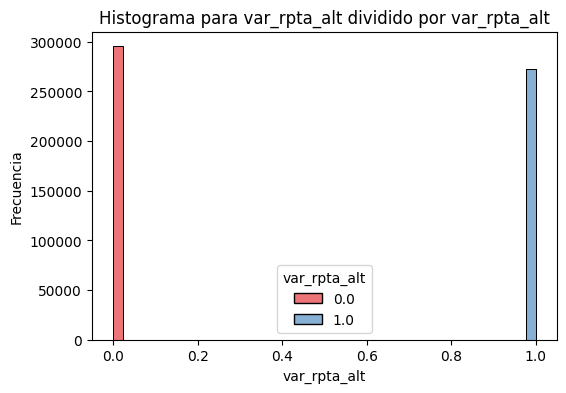

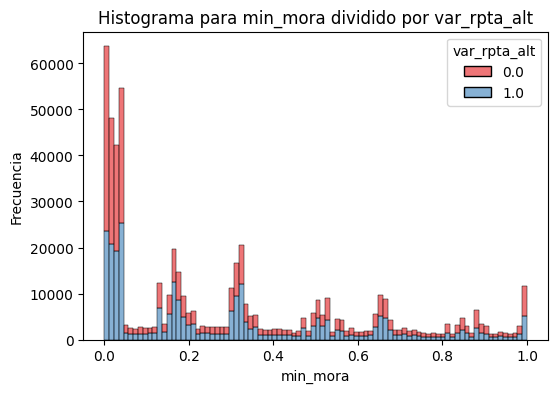

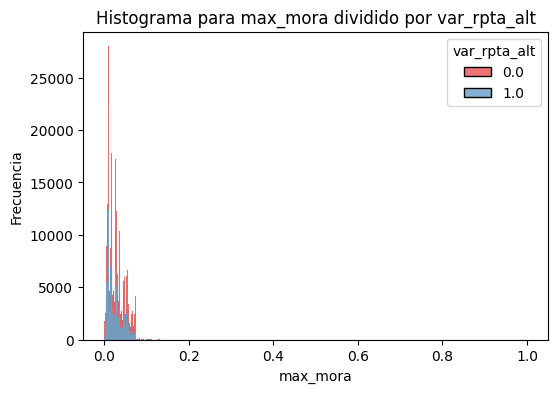

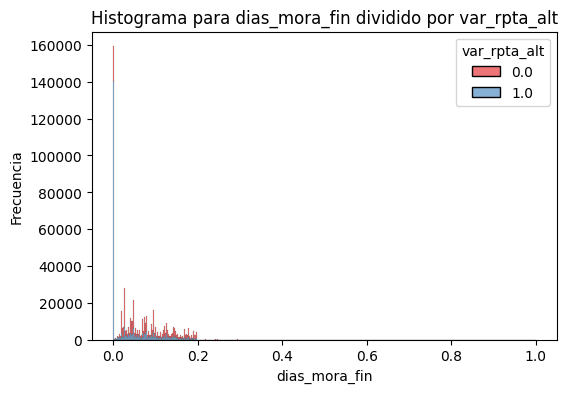

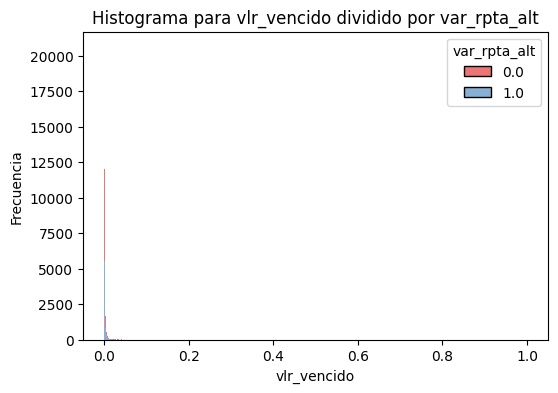

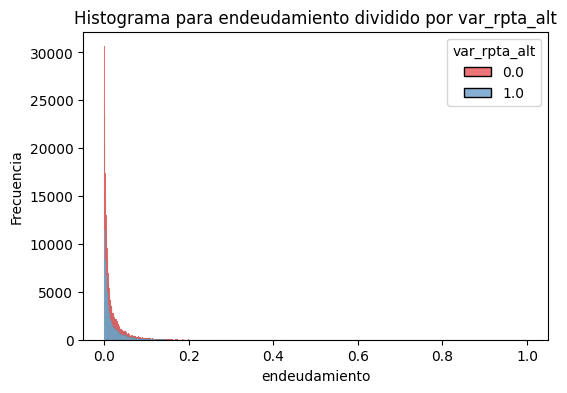

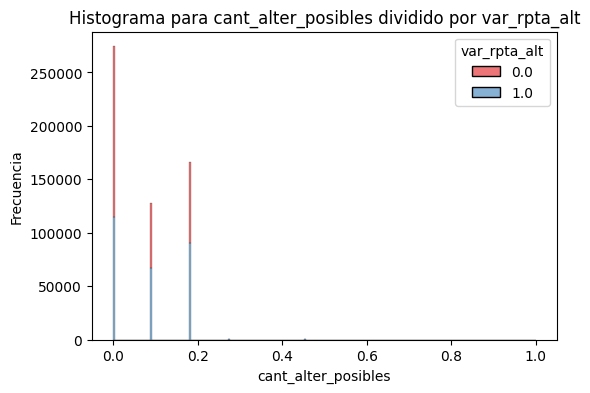

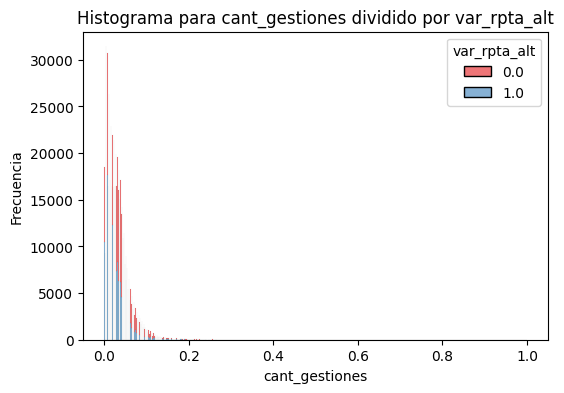

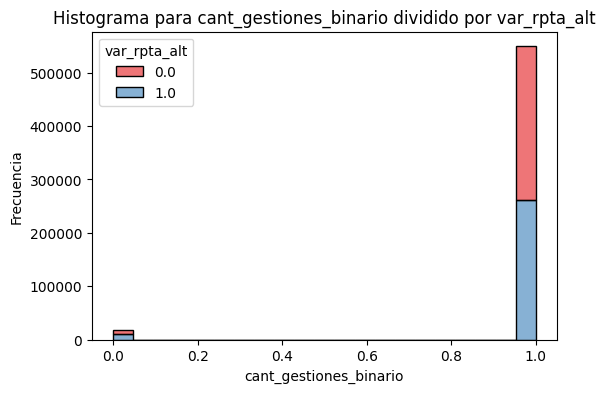

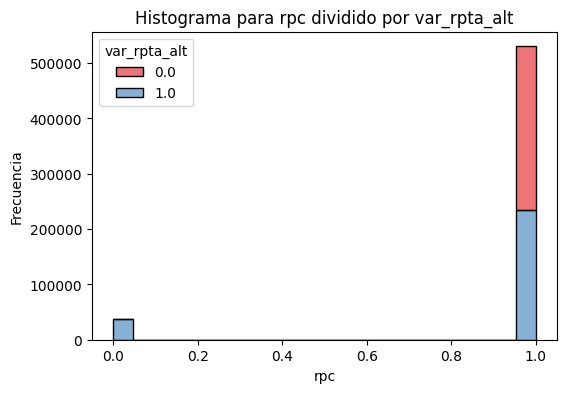

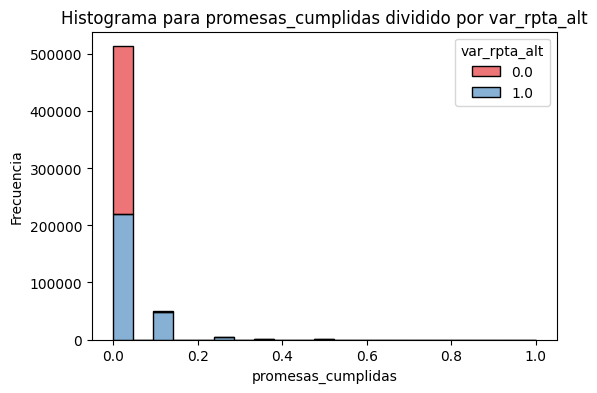

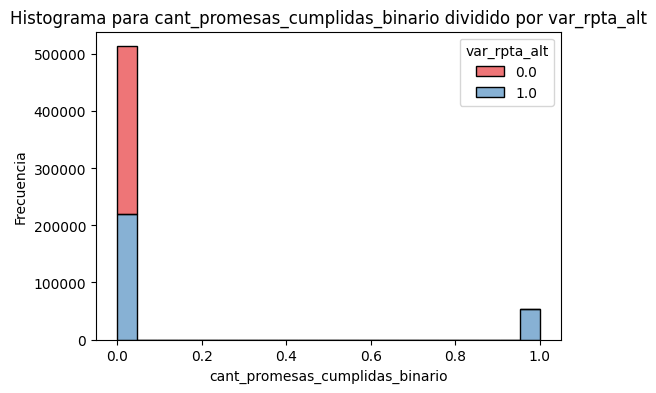

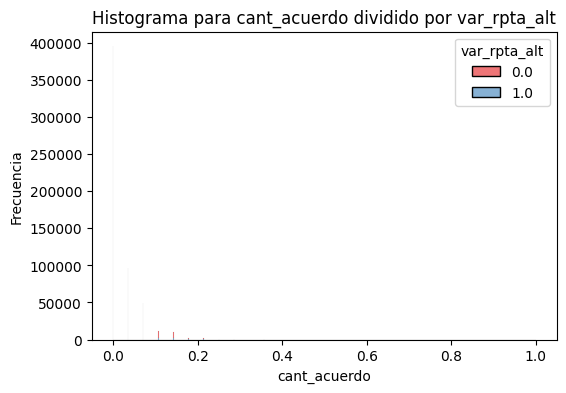

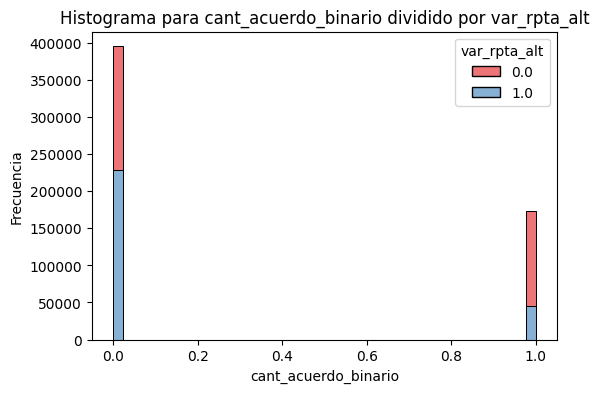

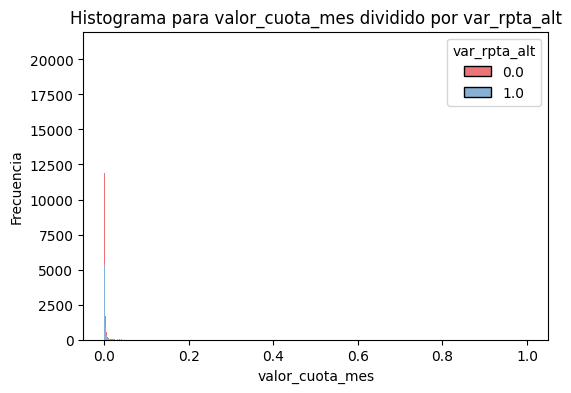

In [ ]:
### Se grafican las distribuciones de las variables cuantitativas

# Seleccionar las variables cuantitativas (float64 e int64)
quantitative = df_merged.select_dtypes(include=['float64', 'int64']).columns

# Iterar sobre cada variable cuantitativa
for var in quantitative:
    plt.figure(figsize=(6, 4))  # Tamaño de cada figura
    sns.histplot(data=df_merged, x=var, hue="var_rpta_alt", multiple="stack", kde=False, palette="Set1", alpha=0.6)
    plt.title(f"Histograma para {var} dividido por var_rpta_alt")
    plt.xlabel(var)
    plt.ylabel('Frecuencia')
    plt.show()

<H5 align="justify">De acuerdo a las gráficas anteriores, no vemos variables potenciales a eliminar porque en todas tengo representatividad de la clase 0-1, sin embargo hay unas variables como "cant_gestiones_binario", "rpc", "promesas_cumplidas", "cant_promesas_cumplidas_binario", "cant_acuerdo_binario", entre otras, que me muestran que aportan a la discriminación de las clases. <H5 align="justify">

**Nota: Se resalta que presentamos la variable dependiente con clases balanceadas**

## **Manejo de valores ausentes**



Luego de haber encontrado que teniamos variables con valores ausentes, empezaremos a trabajar con estas variables para realizar una imputación

1. **Variables categóricas:** Para estas variables los valores ausentes los dejaré en una clase separada imputandole un valor de -99 para que me queden como 1 clase en cada variable (posteriomente usaré One Hot Encoding)

Nota: A la variable lote que es numérica, se le dará el mismo tratamiento

In [44]:
#Seleccionamos las columnas categóricas del DataFrame
categorical_cols = df_merged.select_dtypes(include=['string']).columns

# Imputar los valores ausentes en las columnas categóricas por la cadena '-99'
df_merged[categorical_cols] = df_merged[categorical_cols].fillna('-99')

In [45]:
#Revisaremos si las variables categóricas quedaron con algun valor ausente

valores_perdidos(df_merged.select_dtypes(include=['string']))

El dataframe tiene 30 columnas.
Hay 0 columnas que tienen valores perdidos.


,Valores perdidos,% del total,Tipo


In [46]:
#la variable lote también imputamos con -99, me quedo en tipo objeto entonces debi hacer la conversión hasta llevarlo a string

df_merged['lote'] = df_merged['lote'].fillna('-99.').astype('float64').astype('int').astype('string')

#Revisaremos si la variable lote quedo con algun valor ausente
df_merged['lote'].unique()

<StringArray>
['1', '2', '3', '-99']
Length: 4, dtype: string

2. Las variables asociadas a los pagos o gestiones las imputaré con "0" porque asumo que el cliente no pago o no tuvo acuerdos-gestiones

In [47]:
df_merged[['porc_pago_mes','cant_acuerdo','cant_gestiones','porc_pago','pago_cuota','valor_cuota_mes','rpc']] = df_merged[['porc_pago_mes','cant_acuerdo','cant_gestiones','porc_pago','pago_cuota','valor_cuota_mes','rpc']].fillna(0)

In [48]:
#reviso si quedaron con algun valor ausente

valores_perdidos(df_merged[['porc_pago_mes','cant_acuerdo','cant_gestiones','porc_pago','pago_cuota','valor_cuota_mes','rpc']])

El dataframe tiene 7 columnas.
Hay 0 columnas que tienen valores perdidos.


,Valores perdidos,% del total,Tipo


In [49]:
valores_perdidos(df_merged)


El dataframe tiene 64 columnas.
Hay 13 columnas que tienen valores perdidos.


,Valores perdidos,% del total,Tipo
personas_dependientes,123751,21.8,float64
edad_cli,123750,21.8,float64
num_hijos,123750,21.8,float64
total_ing,111963,19.7,float64
tot_activos,111963,19.7,float64
tot_pasivos,111963,19.7,float64
f_vinc,111963,19.7,float64
egresos_mes,111963,19.7,float64
tot_patrimonio,111963,19.7,float64
prob_propension,4361,0.8,float64


3. Las variables asociadas a las probabilidades de los modelos se imputaran con la mediana ("prob_propension", "prob_alrt_temprana","prob_auto_cura")

In [50]:
#Imputaremos con la mediana en estas 3 variables

df_merged['prob_propension'] = df_merged['prob_propension'].fillna(df_merged['prob_propension'].median())

df_merged['prob_alrt_temprana'] = df_merged['prob_alrt_temprana'].fillna(df_merged['prob_alrt_temprana'].median())

df_merged['prob_auto_cura'] = df_merged['prob_auto_cura'].fillna(df_merged['prob_auto_cura'].median())

In [51]:
valores_perdidos(df_merged[['prob_propension','prob_alrt_temprana','prob_auto_cura']])


El dataframe tiene 3 columnas.
Hay 0 columnas que tienen valores perdidos.


,Valores perdidos,% del total,Tipo


4. Revisaré las variables de "personas_dependientes" y "num_hijos" para entender si los valores ausentes sería el cero "0" o realmente esta ausente. En dado caso lo imputare con 0 asumiendo que no tienen.

In [52]:
df_merged['personas_dependientes'].unique()

array([ 0., nan,  1.,  4.,  2.,  3.,  5.,  6., 11.,  7., 10.,  8.,  9.,
       91., 20., 21., 22., 60., 12., 30., 15., 13., 16., 40., 31., 32.,
       24.])

In [53]:
df_merged['num_hijos'].unique()

array([ 0., nan,  1.,  3.,  2.,  4.,  5.,  6., 10.,  7.,  8., 83.,  9.,
       11., 12., 33., 22., 20., 96., 21., 55., 23., 63., 73., 13.])

In [54]:
#la variable personas_dependientes y num_hijos la imputaremos con cero "0"

df_merged['personas_dependientes'] = df_merged['personas_dependientes'].fillna('0.').astype('float64')
df_merged['num_hijos'] = df_merged['num_hijos'].fillna('0.').astype('float64')

#Revisaremos si las variables quedaron con algun valor ausente
valores_perdidos(df_merged[['personas_dependientes','num_hijos']])

El dataframe tiene 2 columnas.
Hay 0 columnas que tienen valores perdidos.


,Valores perdidos,% del total,Tipo


5. Finalmente las variables numéricas que continuan con valores ausentes las volveré categóricas partiendola en rangos por quintiles, y los valores ausentes les imputaré el valor '-99' para que me queden en otro grupo

In [55]:
valores_perdidos(df_merged)

El dataframe tiene 64 columnas.
Hay 8 columnas que tienen valores perdidos.


,Valores perdidos,% del total,Tipo
edad_cli,123750,21.8,float64
total_ing,111963,19.7,float64
tot_activos,111963,19.7,float64
tot_pasivos,111963,19.7,float64
f_vinc,111963,19.7,float64
egresos_mes,111963,19.7,float64
tot_patrimonio,111963,19.7,float64
vlr_obligacion,666,0.1,float64


In [56]:
df_merged['edad_cli'] = pd.qcut(df_merged['edad_cli'].dropna(), 5, labels=["1", "2", "3", "4", "5"], duplicates='drop')
df_merged['edad_cli'] = df_merged['edad_cli'].astype("string").fillna("-99")
df_merged['edad_cli'].unique()

<StringArray>
['1', '4', '5', '-99', '3', '2']
Length: 6, dtype: string

In [57]:
df_merged['total_ing'] = pd.qcut(df_merged['total_ing'].dropna(), 5, labels=["1", "2", "3", "4", "5"], duplicates='drop')
df_merged['total_ing'] = df_merged['total_ing'].astype("string").fillna("-99")
df_merged['total_ing'].unique()

<StringArray>
['1', '2', '5', '-99', '3', '4']
Length: 6, dtype: string

In [58]:
df_merged['tot_activos'] = pd.qcut(df_merged['tot_activos'].dropna(), 5, labels=["1", "2", "3", "4", "5"], duplicates='drop')
df_merged['tot_activos'] = df_merged['tot_activos'].astype("string").fillna("-99")
df_merged['tot_activos'].unique()

<StringArray>
['1', '3', '5', '-99', '4', '2']
Length: 6, dtype: string

In [59]:
df_merged['f_vinc'] = pd.qcut(df_merged['f_vinc'].dropna(), 5, labels=["1", "2", "3", "4", "5"], duplicates='drop')
df_merged['f_vinc'] = df_merged['f_vinc'].astype("string").fillna("-99")
df_merged['f_vinc'].unique()

<StringArray>
['5', '4', '1', '-99', '3', '2']
Length: 6, dtype: string

In [60]:
df_merged['egresos_mes'] = pd.qcut(df_merged['egresos_mes'].dropna(), 5, labels=["1", "2", "3", "4", "5"], duplicates='drop')
df_merged['egresos_mes'] = df_merged['egresos_mes'].astype("string").fillna("-99")
df_merged['egresos_mes'].unique()

<StringArray>
['1', '2', '5', '-99', '3', '4']
Length: 6, dtype: string

In [61]:
df_merged['tot_patrimonio'] = pd.qcut(df_merged['tot_patrimonio'].dropna(), 5, labels=["1", "2", "3", "4", "5"], duplicates='drop')
df_merged['tot_patrimonio'] = df_merged['tot_patrimonio'].astype("string").fillna("-99")
df_merged['tot_patrimonio'].unique()

<StringArray>
['1', '3', '5', '-99', '4', '2']
Length: 6, dtype: string

In [62]:
df_merged['vlr_obligacion'] = pd.qcut(df_merged['vlr_obligacion'].dropna(), 5, labels=["1", "2", "3", "4", "5"], duplicates='drop')
df_merged['vlr_obligacion'] = df_merged['vlr_obligacion'].astype("string").fillna("-99")
df_merged['vlr_obligacion'].unique()

<StringArray>
['4', '5', '3', '1', '2', '-99']
Length: 6, dtype: string

6. Dado que la variable de "tot_pasivos" posee en su mayoría valores de cero, se imputará los valores ausentes con cero "0"

In [63]:
df_merged['tot_pasivos'] = df_merged['tot_pasivos'].fillna('0.').astype('float64')

Finalmente revisamos y ya no contamos con valores perdidos en el dataframe

In [64]:
valores_perdidos(df_merged)

El dataframe tiene 64 columnas.
Hay 0 columnas que tienen valores perdidos.


,Valores perdidos,% del total,Tipo


## **Variables dummies: categóricas**

Usaremos get_dummies para transformar las variables categóricas en un formato que puede ser entendido por algoritmos de machine learning, en este caso en variables numéricas binarias (0 o 1), que representan la presencia o ausencia de cada categoría.

In [65]:
#Se listan el total de variables y se desagregan por tipo
cat = len(df_merged.select_dtypes(include=['string']).columns)
num = len(df_merged.select_dtypes(include=['int64','float64']).columns)
print('Total de Variables: ', cat, 'categóricas', '+',num, 'numéricas', '=', cat+num, 'variables')

Total de Variables:  38 categóricas + 26 numéricas = 64 variables


In [66]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568254 entries, 0 to 568253
Data columns (total 64 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   var_rpta_alt                     568254 non-null  int64  
 1   banca                            568254 non-null  string 
 2   segmento                         568254 non-null  string 
 3   producto                         568254 non-null  string 
 4   producto_cons                    568254 non-null  string 
 5   aplicativo                       568254 non-null  string 
 6   min_mora                         568254 non-null  int64  
 7   max_mora                         568254 non-null  int64  
 8   dias_mora_fin                    568254 non-null  int64  
 9   rango_mora                       568254 non-null  string 
 10  vlr_obligacion                   568254 non-null  string 
 11  vlr_vencido                      568254 non-null  float64
 12  en

In [67]:
# Seleccionar las variables categóricas (string)
categorical_cols = df_merged.select_dtypes(include=['string']).columns

# Aplicar One-Hot Encoding a las variables categóricas
df_merged = pd.get_dummies(df_merged, columns=categorical_cols, drop_first=True)

# Mostrar el DataFrame codificado
df_merged

,var_rpta_alt,min_mora,max_mora,dias_mora_fin,vlr_vencido,endeudamiento,cant_alter_posibles,cant_gestiones,cant_gestiones_binario,rpc,...,ciiu_TRANSPORTE FÉRREO DE PASAJEROS,ciiu_TRANSPORTE MIXTO,ciiu_TRANSPORTE POR TUBERÍAS,ciiu_TRATAMIENTO Y DISPOSICIÓN DE DESECHOS NO PELIGROSOS,ciiu_TRATAMIENTO Y DISPOSICIÓN DE DESECHOS PELIGROSOS,ciiu_TRATAMIENTO Y REVESTIMIENTO DE METALES; MECANIZADO,ciiu_TRILLA DE CAFÉ,ajustes_banco_AJUSTES,ajustes_banco_NO,ajustes_banco_REDIFERIDOS
0,1,46,71,71,1000259.0,12134572.0,1,46.0,1,1.0,...,False,False,False,False,False,False,False,False,True,False
1,1,16,24,0,443638.0,15479703.0,2,10.0,1,1.0,...,False,False,False,False,False,False,False,False,True,False
2,1,36,65,65,7650063.0,95148044.0,3,50.0,1,0.0,...,False,False,False,False,False,False,False,False,True,False
3,1,18,40,0,266898.0,47499162.0,2,12.0,1,1.0,...,False,False,False,False,False,False,False,False,True,False
4,1,18,32,32,43471.0,241003241.0,3,10.0,1,1.0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568249,0,29,57,57,1832292.0,63276048.0,2,54.0,1,1.0,...,False,False,False,False,False,False,False,False,True,False
568250,0,5,26,26,805070.0,2812265.0,2,16.0,1,1.0,...,False,False,False,False,False,False,False,False,True,False
568251,0,2,29,29,1144163.0,10222434.0,2,52.0,1,1.0,...,False,False,False,False,False,False,False,False,True,False
568252,1,15,39,0,406405.0,3395735.0,2,32.0,1,1.0,...,False,False,False,False,False,False,False,False,True,False


## **Escalado de variables numéricas**

Usaremos MinMaxScaler

In [68]:
from sklearn.preprocessing import MinMaxScaler

# Seleccionar las columnas numéricas del DataFrame
numerical_cols = df_merged.select_dtypes(include=['float64', 'int64']).columns

# Inicializar el escalador MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar las columnas numéricas con el MinMaxScaler
df_merged[numerical_cols] = scaler.fit_transform(df_merged[numerical_cols])

In [69]:
df_merged

,var_rpta_alt,min_mora,max_mora,dias_mora_fin,vlr_vencido,endeudamiento,cant_alter_posibles,cant_gestiones,cant_gestiones_binario,rpc,...,ciiu_TRANSPORTE FÉRREO DE PASAJEROS,ciiu_TRANSPORTE MIXTO,ciiu_TRANSPORTE POR TUBERÍAS,ciiu_TRATAMIENTO Y DISPOSICIÓN DE DESECHOS NO PELIGROSOS,ciiu_TRATAMIENTO Y DISPOSICIÓN DE DESECHOS PELIGROSOS,ciiu_TRATAMIENTO Y REVESTIMIENTO DE METALES; MECANIZADO,ciiu_TRILLA DE CAFÉ,ajustes_banco_AJUSTES,ajustes_banco_NO,ajustes_banco_REDIFERIDOS
0,1.0,0.505618,0.043451,0.116585,0.001991,0.006456,0.000000,0.044660,1.0,1.0,...,False,False,False,False,False,False,False,False,True,False
1,1.0,0.168539,0.014277,0.000000,0.000883,0.008236,0.090909,0.009709,1.0,1.0,...,False,False,False,False,False,False,False,False,True,False
2,1.0,0.393258,0.039727,0.106732,0.015228,0.050625,0.181818,0.048544,1.0,0.0,...,False,False,False,False,False,False,False,False,True,False
3,1.0,0.191011,0.024209,0.000000,0.000531,0.025273,0.090909,0.011650,1.0,1.0,...,False,False,False,False,False,False,False,False,True,False
4,1.0,0.191011,0.019243,0.052545,0.000087,0.128230,0.181818,0.009709,1.0,1.0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568249,0.0,0.314607,0.034761,0.093596,0.003647,0.033667,0.090909,0.052427,1.0,1.0,...,False,False,False,False,False,False,False,False,True,False
568250,0.0,0.044944,0.015518,0.042693,0.001603,0.001496,0.090909,0.015534,1.0,1.0,...,False,False,False,False,False,False,False,False,True,False
568251,0.0,0.011236,0.017381,0.047619,0.002278,0.005439,0.090909,0.050485,1.0,1.0,...,False,False,False,False,False,False,False,False,True,False
568252,1.0,0.157303,0.023588,0.000000,0.000809,0.001807,0.090909,0.031068,1.0,1.0,...,False,False,False,False,False,False,False,False,True,False


## **Selección de variables con Recursive Feature Elimination Cross Validation (RFECV)**

Para la selección final de características y lograr reducir la dimensionalidad del conjunto de datos, haremos uso de RFE que nos ayudará a seleccionar las características más importantes que contribuyen al rendimiento del modelo, eliminando aquellas que son menos relevantes.

**Nota:** Inicialmente probe con RFE sin validación cruzada, y con un RandomForest o un DecisionTree para la selección de características pero estaba consumiendo la memoria RAM. Posteriomente probe con regresión logística y continuaba sin memoria. Decidi pasarme a un RFECV con una regresión logistica y tome una muestra del dataframe.

**Nota2:** Se hizo varias pruebas con el # de características a retirar en cada iteración y aumentando el # de iteraciones de la regresión logística. **Finalmente decido quedarme con las 492 variables seleccionadas por esta metodología.**

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

# Seleccionamos una muestra del conjunto de datos
df_sampled = df_merged.sample(frac=0.1, random_state=0)  # Usamos solo el 20% de los datos

# Seleccionamos las variables independientes y la variable dependiente
X = df_sampled.drop(columns=['var_rpta_alt'])
y = df_sampled['var_rpta_alt']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Inicializamos un modelo de LogisticRegression
model = LogisticRegression(max_iter=1000, random_state=0)

# Inicializamos el RFECV
rfecv = RFECV(estimator=model, step=20, cv=5, scoring='f1', n_jobs=-1)

# Ajustamos el RFE al conjunto de datos de entrenamiento
rfecv.fit(X_train, y_train)

# Verificar las características seleccionadas
selected_features = X.columns[rfecv.support_]
print(f"Variables seleccionadas: {selected_features}")

Variables seleccionadas: Index(['min_mora', 'dias_mora_fin', 'vlr_vencido', 'endeudamiento',
       'cant_alter_posibles', 'cant_gestiones', 'cant_gestiones_binario',
       'rpc', 'promesas_cumplidas', 'cant_promesas_cumplidas_binario',
       ...
       'ciiu_TRANSPORTE AÉREO INTERNACIONAL DE PASAJEROS',
       'ciiu_TRANSPORTE FÉRREO DE CARGA',
       'ciiu_TRANSPORTE FÉRREO DE PASAJEROS', 'ciiu_TRANSPORTE MIXTO',
       'ciiu_TRANSPORTE POR TUBERÍAS',
       'ciiu_TRATAMIENTO Y REVESTIMIENTO DE METALES; MECANIZADO',
       'ciiu_TRILLA DE CAFÉ', 'ajustes_banco_AJUSTES', 'ajustes_banco_NO',
       'ajustes_banco_REDIFERIDOS'],
      dtype='object', length=492)


In [71]:
rfecv.n_features_

492

Finalmente el número óptimo de variables seleccionadas por la metodología RFECV fueron 492, estas las usaremos para entrenar nuestros modelos.

In [72]:
df_final = pd.concat([df_merged['var_rpta_alt'],df_merged_ids, df_merged[selected_features]], axis=1)

df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568254 entries, 0 to 568253
Columns: 497 entries, var_rpta_alt to ajustes_banco_REDIFERIDOS
dtypes: bool(471), float64(22), int64(4)
memory usage: 368.0 MB


Voy a entender cuantos registros hay de cada mes y por clase.

In [73]:
df_final.groupby(['fecha_var_rpta_alt','var_rpta_alt']).size()


fecha_var_rpta_alt  var_rpta_alt
202308              0.0             58590
                    1.0             54941
202309              0.0             61357
                    1.0             59828
202310              0.0             62236
                    1.0             53687
202311              0.0             59876
                    1.0             57273
202312              0.0             53425
                    1.0             47041
dtype: int64

Revisando el # de registros que tenemos por fecha de respuesta encuentro que estan muy balanceados. Procedere a partir las bases para train (Agosto a Octubre), test (Noviembre) y validation (Diciembre)

In [74]:
df_final_train = df_final[df_final['fecha_var_rpta_alt'].isin([202308, 202309,202310])]

In [75]:
df_final_test = df_final[df_final['fecha_var_rpta_alt'].isin([202311])]

In [76]:
df_final_val = df_final[df_final['fecha_var_rpta_alt'].isin([202312])]

## **Selección de Modelo de clasificación**

Finalmente, luego de haber preparado los datos y teniendolos en el formato adecuado para modelar, procedere a probar una lista de modelos (regresión logistica, bosques aleatorios, k vecinos mas cercanos y gradient boosting) para ver cual presenta un mejor performance por la métrica F1 Score.

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

# Crear una lista de algoritmos a probar
algoritmos = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=0),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=0)
}


#Creo las variables dependientes e independiente en train y test
X_train = df_final_train.drop(['var_rpta_alt','nit_enmascarado','num_oblig_orig_enmascarado','num_oblig_enmascarado','fecha_var_rpta_alt'], axis=1)
y_train = df_final_train['var_rpta_alt']
X_test = df_final_test.drop(['var_rpta_alt','nit_enmascarado','num_oblig_orig_enmascarado','num_oblig_enmascarado','fecha_var_rpta_alt'], axis=1)
y_test = df_final_test['var_rpta_alt']
X_val = df_final_val.drop(['var_rpta_alt','nit_enmascarado','num_oblig_orig_enmascarado','num_oblig_enmascarado','fecha_var_rpta_alt'], axis=1)
y_val = df_final_val['var_rpta_alt']

# Probar cada algoritmo y evaluar su precisión
for nombre, modelo in algoritmos.items():
    # Entrenar el modelo
    modelo.fit(X_train, y_train)

    # Predecir en el conjunto de prueba
    y_pred = modelo.predict(X_test)

    # Evaluar la precisión en el conjunto de prueba
    f1  = f1_score(y_test, y_pred)

    print(f"{nombre} - f1 score en el conjunto de prueba: {f1}")

Logistic Regression - f1 score en el conjunto de prueba: 0.8224957085915452
Random Forest - f1 score en el conjunto de prueba: 0.8461739503798981
KNN - f1 score en el conjunto de prueba: 0.7308657288642065
Gradient Boosting - f1 score en el conjunto de prueba: 0.8406395337977922


Luego de haber entrenado con los datos de validación y testeo con estos 4 modelos, me quedo con el que esta presentando un mejor comportamiento: Random Forest. Con este haré una validación con los datos de diciembre para revisar que no este presentando problemas de sub o sobre entrenamiento.

In [78]:
# Evaluar el mejor modelo en el conjunto de validación
mejor_modelo = RandomForestClassifier(n_estimators=100, random_state=0)
mejor_modelo.fit(X_train, y_train)
y_pred_val = mejor_modelo.predict(X_val)
f1_val =  f1_score(y_val, y_pred_val)
print(f"Mejor modelo (Random Forest) - f1 score en el conjunto de validación: {f1_val}")

Mejor modelo (Random Forest) - f1 score en el conjunto de validación: 0.8344610542879622


Construimos la matriz de confusión y revisamos las métricas de accuracy y Recall (La métrica definida para este modelo fue el f1 Score)

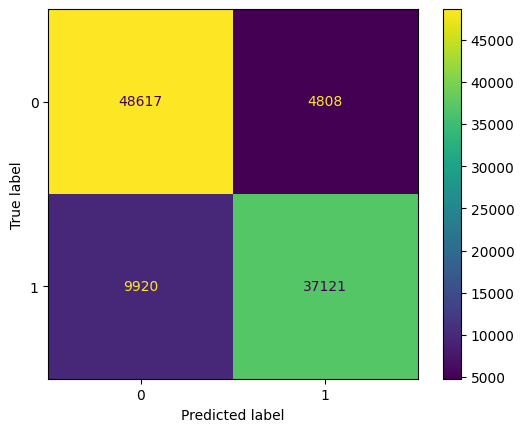

In [79]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_val, y_pred_val)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [94]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87     53425
         1.0       0.89      0.79      0.83     47041

    accuracy                           0.85    100466
   macro avg       0.86      0.85      0.85    100466
weighted avg       0.86      0.85      0.85    100466



Encontramos que el modelo esta teniendo una buena identificación de la clase verdadera (Recall) y esta clasificando bien las 2 clases (Accuracy)

Luego de revisar los datos de validación, encuentro que el modelo esta siendo consistente y será el seleccionado para predecir con los clientes de Enero 2024

## **Predicción de clientes 202401**

In [80]:
#creamos la variable ID en los dataframe de validacion (Diciembre) y OOT concatenando los 3 campos indicados y la ponemos en la primera columna

df_final_val.insert(0, 'ID', df_final_val.nit_enmascarado.astype(str)+'#'+df_final_val.num_oblig_orig_enmascarado.astype(str)+'#'+df_final_val.num_oblig_enmascarado.astype(str))

df_oot.insert(0, 'ID', df_oot.nit_enmascarado.astype(str)+'#'+df_oot.num_oblig_orig_enmascarado.astype(str)+'#'+df_oot.num_oblig_enmascarado.astype(str))


Uniremos el dataframe a pronosticar (oot) con los datos de diciembre (validation) para poder realizar el pronóstico de 202401 según el comportamiento del mes anterior.

In [81]:
df_oot_vf = pd.merge(df_final_val, df_oot, left_on=["ID"], right_on= ["ID"], how="inner")

Revisaremos cuantos registros a pronosticar tiene el dataframe OOT y cuantos quedaron luego de unirla con los datos de Diciembre

In [82]:
print("El número de registros a pronosticar en 202401 son",df_oot.shape[0])

print("El número de registros que cuentan con info para pronosticar en 202401 son",df_oot_vf.shape[0])

El número de registros a pronosticar en 202401 son 112549
El número de registros que cuentan con info para pronosticar en 202401 son 29040


Según lo anterior, solo contamos con datos en Diciembre del 25% de los clientes a pronosticar en 202401.

Revisarmos la validación de ver si los clientes de OOT se encuentran o no en los dataframe de Train (tabla pivote) y de customers

In [83]:
df_train.insert(0, 'ID', df_train.nit_enmascarado.astype(str)+'#'+df_train.num_oblig_orig_enmascarado.astype(str)+'#'+df_train.num_oblig_enmascarado.astype(str))


In [84]:
df_oot_train = pd.merge(df_train, df_oot, left_on=["ID"], right_on= ["ID"], how="inner")

In [85]:
print("El número de registros a pronosticar en 202401 son",df_oot.shape[0])

print("El número de registros para pronosticar 202401 en tabla pivote son",df_oot_train.shape[0])

El número de registros a pronosticar en 202401 son 112549
El número de registros para pronosticar 202401 en tabla pivote son 85385


Revisando en la tabla pivote encontramos información en alguno de los meses (Recordar que la tabla pivote tiene 5 meses) del 75% de los clientes a pronósticar.

**Concluyo que no tenemos información para pronosticar todos los clientes del 202401, en este caso tendría que ir a buscarse en las bases de datos fuentes donde tenemos la información de estos registros.**

Se hará el ejercicio de pronosticar los 29mil clientes que si cuentan con información a diciembre.

In [86]:
#Dejo los datos de los clientes oot a pronosticar en 202401

X_oot = df_oot_vf.drop(["ID","var_rpta_alt","nit_enmascarado_x","num_oblig_orig_enmascarado_x","num_oblig_enmascarado_x","fecha_var_rpta_alt_x","fecha_var_rpta_alt_y","nit_enmascarado_y","num_oblig_enmascarado_y","num_oblig_orig_enmascarado_y"],axis=1)
ID_oot = df_oot_vf.ID

In [87]:
#Pronostico y saco la probabilidad de la clase 1 y lo guardo en el dataframe ID_oot y le pongo el nombre indicado en Kaggle
prediccion = pd.DataFrame(modelo.predict(X_oot),dtype='int',columns=['var_rpta_alt'])
probabilidad = pd.DataFrame(modelo.predict_proba(X_oot)[:, 1],columns=['Prob_uno'])

In [88]:
resultado_prueba = pd.merge(df_oot,pd.concat([ID_oot,prediccion, probabilidad], axis=1),left_on=["ID"], right_on= ["ID"], how="left").drop(["nit_enmascarado","num_oblig_orig_enmascarado","num_oblig_enmascarado","fecha_var_rpta_alt"],axis=1)

In [89]:
resultado_prueba.to_csv("resultado_prueba.csv",index=False)

In [90]:
#Para poder subir el archivo de submission en Kaggle voy a rellenar las predicciones de los clientes que no tengo con "0" solo para validar que el formato este correcto.
submission = pd.merge(df_oot,pd.concat([ID_oot,prediccion],axis=1),left_on=["ID"], right_on= ["ID"], how="left").drop(["nit_enmascarado","num_oblig_orig_enmascarado","num_oblig_enmascarado","fecha_var_rpta_alt"],axis=1).fillna(0)

In [91]:
submission.to_csv("submission.csv",index=False)

Finalmente guardaré el modelo resultante para ser usado en próximos meses

In [92]:
import joblib

# Supongamos que tu modelo se llama 'modelo'
# Guardar el modelo en un archivo
joblib.dump(modelo, 'modelo_entrenado.pkl')

['modelo_entrenado.pkl']

## **Despliegue del modelo**

Es clave realizar una documentación detallada del modelo para garantizar la trazabilidad, reproducibilidad y claridad para cualquier equipo que desee utilizarlo o mejorarlo en el futuro. Este debe contener:

*   Descripción del problema, objetivo y métrica de evaluación
*   Descripción de los datos, fuente y preprocesamiento
*   Arquitectura del modelo seleccionado
*   Evaluación del modelo
*   Versiones de las librerías utilizadas para que el modelo sea reproducible en otro entorno (como producción).







## **Monitoreo del modelo**

Una vez que el modelo está en producción, es fundamental monitorearlo y crear un conjunto de alertas para asegurarnos de que esté funcionando correctamente y detectar cualquier deterioro de rendimiento. Si los datos, el entorno o la precisión cambian, puede ser necesario reentrenar el modelo.

# **3. Mejoras al modelo**

*   Todo este proceso fue realizado en Google Colab, y al contar con una memoria RAM limitada presentaba problemas de rendimiento al aplicar diferentes procesos, por lo que tuve que tomar algunas decisiones (como muestrar el dataframe para el RFECV) y no pude experimentar mucho con los hiperparametros ni con otros modelos.
*   Si pudieramos tener un mayor contexto desde negocio de cada una de las variables que tenemos dentro de los Dataframe podríamos darles una mejor interpretación y definir como usarlas en el modelo.
*   Por efectos de tiempo no pude probar otras metodologías para la limpieza, depuración y selección de variables. Para lograr un mejor performance del modelo es necesario probarlo. Además tampoco alcance a realizar un Pipeline que ayude a automatizar y estandarizar todo el proceso que se debe realizar hasta llegar a los pronósticos.
*   Por tiempo no alcancé a revisar la matriz de confusión para revisar como estaban pronosticando los modelos cada una de las clases. Solo trabaje con el f1 Score  
*   No contabamos con información de la tabla customers para todos los clientes que estaban en la tabla pivote. Contar con esta información nos ayudaría a mejorar todo el proceso de construcción del modelo.
*   **De los 112mil registros a pronosticar en 202401, el 25% no estaban en la tabla pivote y con datos para el mes de Diciembre solo estaba el 25% para pronosticar. Es importante contar con la información de estos clientes para poderles generar predicción.**
*   En el metadata mencionan una base llamada "saldos_diarios_cob_enmascarado" pero la base no la entregaron para el modelo. Sería importante tenerla para ver si nos puede ayudar a mejorar el performance de esta solución
*   Para realizar la predicción deje por defecto el umbral de 0.5 para definir la clase. Con más tiempo se puede buscar encontrar el umbral óptimo que maximize el F1 Score.
*   Decidí realizar la partición de las bases de train, test y validation por criterio de experto, sin probar los cambios que me traia a la solución partiendolos de forma diferente. Adicionalmente, hice la suposición que los clientes de 202401 los pronosticaré con la información que tengo de ellos hasta Diciembre.